In [2]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
time_of_interest = "2024-11-01/2024-12-31"

In [5]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 0 Items


In [7]:

selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


In [8]:

max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [9]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset> Size: 7MB
Dimensions:      (y: 747, x: 795)
Coordinates:
  * y            (y) float64 6kB 5.289e+06 5.289e+06 ... 5.266e+06 5.266e+06
  * x            (x) float64 6kB 5.543e+05 5.544e+05 ... 5.781e+05 5.782e+05
    spatial_ref  int32 4B 32610
    time         datetime64[ns] 8B 2021-07-25T18:55:39.475647
Data variables:
    nir08        (y, x) uint16 1MB 7187 7216 7237 7251 ... 20871 20917 23931
    red          (y, x) uint16 1MB 7158 7193 7219 7246 ... 8171 9372 8634 8058
    green        (y, x) uint16 1MB 7489 7518 7541 7570 ... 8771 9580 9062 8709
    blue         (y, x) uint16 1MB 7343 7370 7433 7467 ... 8068 8616 8252 8014
    qa_pixel     (y, x) uint16 1MB 21952 21952 21952 21952 ... 21824 21824 21824
    lwir11       (y, x) uint16 1MB 43466 43464 43468 43471 ... 44431 44355 44229

Text(0.5, 1.0, 'Natural Color, Redmond, WA')

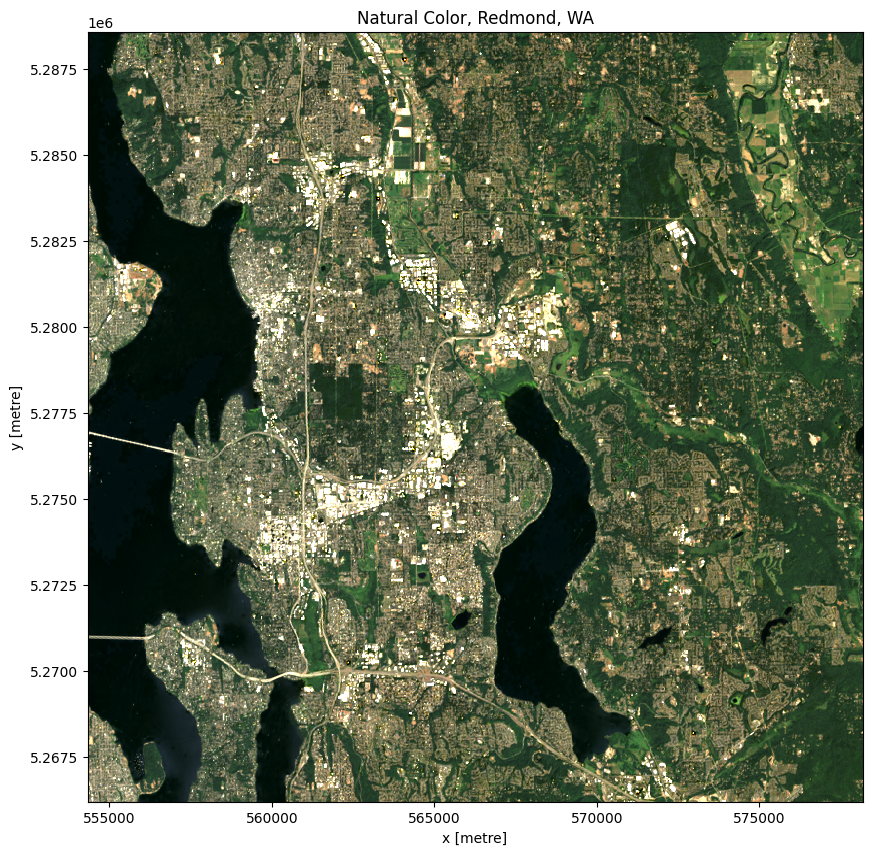

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color, Redmond, WA")